In [58]:
import os
import requests
from dotenv import load_dotenv

# Load environment variables from a .env file 
load_dotenv()

# Retrieve the API key from environment variable
geocode_api_key = os.getenv("GEOCODE_API_KEY")
amadeus_client_id = os.getenv("AMADEUS_CLIENT_ID")
amadeus_client_secret = os.getenv("AMADEUS_CLIENT_SECRET")

# Check if API key is present
if not geocode_api_key:
    raise ValueError("GEOCODE_API_KEY not found in environment variables.")

In [117]:
# let us use Pydantic to get a structured response for use in our application
from pydantic import BaseModel, Field
from typing import List, Optional

# Define the response model to get lat and long as float
class GeoResult(BaseModel):
    lat: float
    lon: float

# Define the structured input needed to get list of attractions from Amadeus API
class AttractionInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location")
    longitude: float = Field(..., description="Longitude of the location")
    radius: Optional[int] = Field(default=20, description="Radius in kilometers for the search area")

# Define the structured input needed to get list of hotels from Amadeus API
class HotelInput(BaseModel):
    city_code: str = Field(..., description="IATA city code (e.g. PAR for Paris)")
    radius: Optional[int] = Field(default=20, description="Radius in kilometers for the search area")

# Define the structured input to get city code needed to get hotel list
class CitySearchInput(BaseModel):
    keyword: str = Field(..., description="City name or partial keyword to search for")
    country_code: Optional[str] = Field(None, description="Optional ISO2 country code to filter results")

# Get lat and long for an address from GeoCode API
def get_lat_long(address: str) -> GeoResult:
    """
    Get latitude and longitude for a given address using the GeoCode API.
    
    :param address: The address to geocode.
    :return: A GeoResult object with lat and lon.
    """

    url = "https://geocode.maps.co/search"
    params = {
        "q": address,
        "api_key": geocode_api_key
    }
    
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"GeoCode API Error: {response.status_code} for address {address}")

    data = response.json()
    if not data:
        raise ValueError("No geocode results found for the given address.")

    return GeoResult.model_validate(data[0])

# Define function to get weather from the lat and lon we get from get_lat_long function
def get_weather(lat: float, lon: float) -> str:
    """
    Fetches the current weather information for a given geographic coordinate.

    This function calls the Open-Meteo API using the provided latitude and longitude
    to retrieve current weather conditions such as temperature and wind speed.

    Parameters:
        lat (float): The latitude of the location.
        lon (float): The longitude of the location.

    Returns:
        str: A human-readable summary of the current weather, including temperature and wind speed.

    Raises:
        Exception: If the weather API call fails or returns a non-200 HTTP status code.
    """

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "current_weather": True
    }
    
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        weather = data.get("current_weather", {})
        return f"The current temperature is {weather.get('temperature')}°C with wind speed {weather.get('windspeed')} km/h."
    else:
        raise Exception(f'Open Meteo Weather API call failed with status code {response.status_code} for lat {lat} & lon {lon}.')
    

def get_amadeus_access_token() -> str:
    """Fetch OAuth token from Amadeus API"""
    url = "https://test.api.amadeus.com/v1/security/oauth2/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "client_credentials",
        "client_id": amadeus_client_id,
        "client_secret": amadeus_client_secret,
    }

    response = requests.post(url, headers=headers, data=data)
    response.raise_for_status()
    return response.json()["access_token"]

In [64]:
# Make the tool to get weather data
from langchain.tools import tool

@tool
def get_weather_for_address(address: str) -> str:
    """
    Tool: Get current weather for a given address.

    This tool geocodes the input address to obtain latitude and longitude,
    then queries the weather API to return current temperature and wind speed
    at that location.

    Parameters:
        address (str): The address to get weather for.

    Returns:
        str: A summary of the current weather for the provided location.
    """
    # Get lat lon into the Pydantic object with lat and lon
    georesult = get_lat_long(address)
    # Send lat lon from Pydantic object to get weather
    return get_weather(georesult.lat, georesult.lon)


In [57]:
address = "1525 E Tonto Dr, Gilbert, AZ 85298"
result = get_weather_for_address.invoke(address)
result

'The current temperature is 42.4°C with wind speed 9.7 km/h.'

In [52]:
result

'The current temperature is 42.4°C with wind speed 9.7 km/h.'

In [ ]:

# Tool to get popular attractions
@tool
def get_popular_attractions(input: AttractionInput) -> List[str]:
    """Get a list of popular attractions near a specified latitude and longitude using the Amadeus API."""
    token = get_amadeus_access_token()
    url = "https://test.api.amadeus.com/v1/shopping/activities"
    params = {
        "latitude": input.latitude,
        "longitude": input.longitude,
        "radius": input.radius
    }
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    
    pois = response.json().get("data", [])
    #names = [poi["name"] for poi in pois if poi.get("name")] -> getting all relevant info below
    print(f'Number of Point of Interests {len(pois)}')
    pois_summaries = []

    for poi in pois:
        name = poi.get("name")
        description = poi.get("shortDescription")
        rating = poi.get("rating")
        price_info = poi.get("price", {})
        price = price_info.get("amount")
        currency = price_info.get("currencyCode")
        summary = f"{name} - Rated {rating}/5, Average Price: {price} {currency}"
        pois_summaries.append(summary)
    
    return pois_summaries or ["No attractions found near this location."]

# Tool to get hotels
# use Amedeus /v3/shopping/hotel-offers end point to get hotels with price. for now getting just hotel names.
@tool
def get_hotels_in_city(input: HotelInput) -> List[str]:
    """
    Get the top 10 hotel names in the specified city with their distance using the city code represeting the city.

    Format: "Hotel Name - X km away"

    Parameters:
        input (HotelInput): Includes city_code and optional radius (in km).

    Returns:
        List[str]: A list of hotel descriptions in the desired format.
    """

    token = get_amadeus_access_token()
    url = "https://test.api.amadeus.com/v1/reference-data/locations/hotels/by-city"
    params = {"cityCode": input.city_code,
              "radius": input.radius}
    headers = {"Authorization": f"Bearer {token}"}
    
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    
    hotels = response.json().get("data", [])
    
    #names = [hotel["name"] for hotel in hotels if "name" in hotel]
    #return names or ["No hotels found for the given city."]

    # Filter and format
    formatted_hotels = []
    for hotel in hotels:
        name = hotel.get("name")
        distance = hotel.get("distance", {}).get("value")
        unit = hotel.get("distance", {}).get("unit", "KM")
        if name and distance is not None:
            formatted_hotels.append((name, distance, unit))

    # Sort by distance and limit to top 10
    formatted_hotels.sort(key=lambda x: x[1])
    top_10 = formatted_hotels[:10]

    # Final string formatting
    return [f"{name} - {distance:.1f}{unit.lower()} away" for name, distance, unit in top_10] or \
           ["No hotels found for the given city."]


# Tool to get city code for the city name
@tool
def city_search(input: CitySearchInput) -> dict:
    """
    Searches for a city code from keyword of the city in the destination address using Amadeus City Search API and returns:
      - city_name
      - iata_code
      - latitude, longitude
      - list of associated airport codes
    """
    token = get_amadeus_access_token()

    params = {"keyword": input.keyword, "include":"AIRPORTS"}
    if input.country_code:
        params["countryCode"] = input.country_code
    url = "https://test.api.amadeus.com/v1/reference-data/locations/cities"
    response = requests.get(url, headers={"Authorization":f"Bearer {token}"}, params=params)
    response.raise_for_status()

    data = response.json().get("data", [])
    if not data:
        return {"error": f"No city found matching '{input.keyword}'"}
    print(f'city data : {data}')
    top = data[0]
    iata = top.get("iataCode")
    lat = top.get("geoCode", {}).get("latitude")
    lon = top.get("geoCode", {}).get("longitude")
    relationships = top.get("relationships", [])
    airports = [rel.get("id") for rel in relationships if rel.get("type") == "Airport"]

    return {"city_name": top.get("name"), "iata_code": iata, "latitude": lat, "longitude": lon, "airports": airports}

In [ ]:
lat = 37.7576713
lon = -122.5200013
rad = 20
input_data=AttractionInput(latitude=lat,longitude=lon,radius=rad)
attractions = get_popular_attractions.invoke({"input" : input_data})


length of data 9


In [95]:
attractions

['California-Caribbean Family Style Dinner // Alamo Square - Rated None/5, Average Price: 120.0 USD',
 'Truffle Risotto Demystified // Mission Bay - Rated None/5, Average Price: 126.0 USD',
 'Sake Tasting & Food Pairing with a Sake Sommelier  - Rated None/5, Average Price: 48.0 USD',
 'Italian Fresh Pasta Ravioli // Potrero Hill - Rated None/5, Average Price: 108.0 USD',
 'New York Style Pizza Class // Mission Bay - Rated None/5, Average Price: 132.0 USD',
 'Paella & Tapas Cooking Class // Mission Bay - Rated None/5, Average Price: 132.0 USD',
 'San Francisco Sizzler: Neapolitan Pizza Making Class - Rated None/5, Average Price: 162.0 USD',
 'Unleash your Inner Artist: Cooking Class and Market Tour in Haight Ashbury - Rated None/5, Average Price: 214.8 USD',
 'Sunday Red Caviar and Crepes Brunch with Mimosas in San Francisco - Rated None/5, Average Price: 54.0 USD']

In [ ]:
# Test to see that city search function works fine to get iatacode for the city
city_keyword = "paris"
input_data=CitySearchInput(keyword=city_keyword)
city_info = city_search.invoke({"input" : input_data})

city data : [{'type': 'location', 'subType': 'city', 'name': 'Paris', 'iataCode': 'PAR', 'address': {'countryCode': 'FR', 'stateCode': 'FR-75'}, 'geoCode': {'latitude': 48.85341, 'longitude': 2.3488}, 'relationships': [{'id': 'BVA', 'type': 'Airport', 'href': '#/included/airports/BVA'}, {'id': 'CDG', 'type': 'Airport', 'href': '#/included/airports/CDG'}, {'id': 'ORY', 'type': 'Airport', 'href': '#/included/airports/ORY'}, {'id': 'XCR', 'type': 'Airport', 'href': '#/included/airports/XCR'}]}, {'type': 'location', 'subType': 'city', 'name': 'Le Touquet-Paris-Plage', 'iataCode': 'LTQ', 'address': {'countryCode': 'FR', 'stateCode': 'FR-62'}, 'geoCode': {'latitude': 50.52432, 'longitude': 1.58571}, 'relationships': [{'id': 'LIL', 'type': 'Airport', 'href': '#/included/airports/LIL'}]}, {'type': 'location', 'subType': 'city', 'name': 'Paris', 'iataCode': 'PHT', 'address': {'countryCode': 'US', 'stateCode': 'US-TN'}, 'geoCode': {'latitude': 36.302, 'longitude': -88.32671}, 'relationships': [{

In [ ]:
# display output
city_info

{'city_name': 'Paris',
 'iata_code': 'PAR',
 'latitude': 48.85341,
 'longitude': 2.3488,
 'airports': ['BVA', 'CDG', 'ORY', 'XCR']}

In [ ]:
# Test get hotels in city function from the city code
city_code = "PAR"
input_hotel_data=HotelInput(city_code=city_code)
hotel_info = get_hotels_in_city.invoke({"input" : input_hotel_data})
    

In [ ]:
# view results of hotel list
hotel_info

['HN TEST PROPERTY1 FOR E2E TESTING - 0.1km away',
 'TEST PROPERTY FOR API ACTIVATE/DE-ACTIVA - 0.1km away',
 'TEST PROPERTY FOR AZURE MIGRATION HCR - 0.1km away',
 'HOTEL LES RIVES DE NOTRE DAME - 0.1km away',
 'BW PREMIER ROYAL SAINT MICHEL - 0.2km away',
 'HOTEL RESIDENCE DES ARTS - 0.2km away',
 'HOTEL VILLA D ESTREES - 0.2km away',
 'HOLIDAY INN PARIS-NOTRE DAME - 0.3km away',
 'CITADINES SAINT GERMAIN PARIS - 0.3km away',
 'HOTEL RELAIS CHRISTINE - 0.4km away']

In [130]:
# Setup OpenAI's GPT-4o model for use with LangChain
from langchain_openai import ChatOpenAI

model = "gpt-4o"
llm = ChatOpenAI(model_name=model, temperature=0.2)

In [131]:
from typing import TypedDict, Annotated, Sequence
# Define AgentState using TypedDict to hold the state of the agent
# using Total=False to allow for optional fields
class AgentState(TypedDict, total=False):
    name: str  # The user's name for personalization
    destination: str  # destination where the user is planning for the trip
    days: int  # number of days the user is planning for the trip
    messages: list[str]  # List of messages to keep track of conversation and activities

# Initialize the agent state with default values
agent_state: AgentState = {
    "name": "",
    "destination": "",
    "days": 0,
    "messages": []
}

In [132]:
# lets build langgraph workflow by importing the necessary components
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [133]:
# Use inbuilt tools from LangChain, DuckDuckGo to search the web as summarized result
# Tavely tool gives web result, that needs to be summarized by LLM for result. DuckDuckGo summarizes the result
from langchain.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

In [134]:
# Use the tools with the model
tools = [city_search, get_hotels_in_city, get_popular_attractions, get_weather_for_address, search]
# bind tools with LLM
llm_with_tools = llm.bind_tools(tools)

In [136]:
# Create system prompt to use in llm function below. put in list to add human message later
system_prompt = [SystemMessage(
    content="""Your are an helpful Trip planning assistant. 
    Your task is to get information such as the user name, destination, number of days in the trip. 
    Ask the user for these info if user has not provided it to you.
    Once you have those info. You get the city code, latitude and longitude for the destination given by the user.
    You will get hotel list from city code. 
    you will get weather information from latitude and longitude.
    You will get list of attractions in the destination from the latitude and longitude.
    The output to the user to be presented are below:
    - weather in the destination city
    - Top 10 attractions and things to do with their cost
    - Top 10 hotels in the destination city
    - An estimate of daily and total cost of the trip
    - Daily plan by day of the trip covering things to do, where to eat and getting around the city
    - Summary of the trip
    Personalize the response to the user"""
)]

# define the node to assess the user query for next step
def assess_user_query(state:AgentState):
    """ Function to assess user query, use relevant tools and summarize response to user query."""    
    
    human_message=state["messages"]

    query = system_prompt + human_message
    
    response = llm_with_tools.invoke(query)
    state["messages"].append(response)
    return state

In [137]:
# use ToolNode to create node fro tool list and prebuilt tools_condition to route tool back to llm or end
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Create the workflow graph
# We add edge from tools to llm_decision to overrides the tools_condition that routes tools to end, to create loop
builder = StateGraph(MessagesState) \
                .add_node("assess_user_query",assess_user_query) \
                .add_node("tools", ToolNode(tools)) \
                .add_edge(START, "assess_user_query") \
                .add_conditional_edges("assess_user_query", tools_condition) \
                .add_edge("tools", "assess_user_query") 

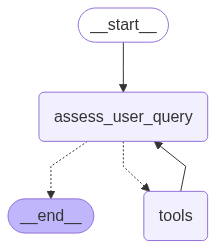

In [138]:
#compile the graph
trip_planner_app = builder.compile()
# visualize the graph
from IPython.display import Image, display
display(Image(trip_planner_app.get_graph().draw_mermaid_png()))

In [139]:
# let us see if the Agent can search the web, then use a tool to calculate and return result to user

message = [HumanMessage(content="I'm Raj. Can you plan a trip for me to san franscisco, california for 4 days")]

results=trip_planner_app.invoke({"messages" : message})

for result in results["messages"]:
    result.pretty_print()

city data : [{'type': 'location', 'subType': 'city', 'name': 'San Francisco', 'iataCode': 'SFO', 'address': {'countryCode': 'US', 'stateCode': 'US-CA'}, 'geoCode': {'latitude': 37.77493, 'longitude': -122.41942}, 'relationships': [{'id': 'SFO', 'type': 'Airport', 'href': '#/included/airports/SFO'}]}, {'type': 'location', 'subType': 'city', 'name': 'San Francisco', 'address': {'countryCode': 'AR', 'stateCode': 'AR-X'}, 'geoCode': {'latitude': -31.42797, 'longitude': -62.08266}, 'relationships': [{'id': 'COR', 'type': 'Airport', 'href': '#/included/airports/COR'}]}, {'type': 'location', 'subType': 'city', 'name': 'San Francisco de Laishi', 'address': {'countryCode': 'AR', 'stateCode': 'AR-P'}, 'geoCode': {'latitude': -26.24262, 'longitude': -58.63039}, 'relationships': [{'id': 'FMA', 'type': 'Airport', 'href': '#/included/airports/FMA'}]}, {'type': 'location', 'subType': 'city', 'name': 'San Francisco del Monte de Oro', 'address': {'countryCode': 'AR', 'stateCode': 'AR-D'}, 'geoCode': {'

In [ ]:
# observations:
#---------------
# LLM did not use the web search to get any additional details. Meaning it successfully used all tools
# LLM gave the results as expected.

# improvements:
#---------------
# Add hotel price in addition to hotel name list. that can be accounted for daily cost and total trip cost estimate
# Make this interactive like chat bot, for LLM to ask all inputs needed from the user to then summarize results